In [20]:
import pandas as pd

## Pull in FTE totals

In [21]:
fte = pd.read_csv("output/total-fte.csv")
print fte.dtypes
fte.head()

City                   object
report_year             int64
Enrollment            float64
FTE Count             float64
Education spending    float64
has_nulls                bool
dtype: object


,City,report_year,Enrollment,FTE Count,Education spending,has_nulls
0,ANDOVER,2007,645.40,60.9,7507964.0,True
1,ANDOVER,2008,642.14,58.0,8829049.0,True
2,ANDOVER,2009,641.76,59.4,8056856.0,True
3,ANDOVER,2010,631.35,60.0,7844581.0,True
4,ANDOVER,2011,636.48,59.7,8009858.0,True


## Pull in grant totals

In [53]:
grants = pd.read_csv("output/grants-year-district-grantname.csv")
grants["VName"] = grants["VName"].str.upper()
# Drop any grants we don't want here
drops = []
keeps = ["EDUCATION EQUALIZATION",
        'ARRA STABILIZATION ED GRANTS', 
         'ARRA STABILIZATION GOV SERV']
print ("Length before drops %d" % len(grants))
grants = grants[grants["GrantName"].apply(lambda x:x not in drops)]
print ("Length after drops %d" % len(grants))
print grants.dtypes
grants.head()

Length before drops 44532
Length after drops 44532
FYEAR          int64
VName         object
GrantName     object
Payment      float64
dtype: object


,FYEAR,VName,GrantName,Payment
0,2004,ANSONIA,ADULT EDUCATION COOPERATIVE,70805.0
1,2004,ANSONIA,CARL D PERKINS VOC TECH EDUC ACT,39617.0
2,2004,ANSONIA,CHILD NUTRITION STATE MATCHING GRANT,15695.0
3,2004,ANSONIA,EARLY READING SUCCESS,201582.0
4,2004,ANSONIA,EDUCATION EQUALIZATION,11971916.0


In [23]:
# Get sums 
grants.columns = ["report_year","City","Grantname","GrantPayment"]
total_grants = grants.groupby(["City","report_year"]).agg({"GrantPayment":sum})

## Combine grant totals and FTE totals

In [24]:
fte.head()

,City,report_year,Enrollment,FTE Count,Education spending,has_nulls
0,ANDOVER,2007,645.40,60.9,7507964.0,True
1,ANDOVER,2008,642.14,58.0,8829049.0,True
2,ANDOVER,2009,641.76,59.4,8056856.0,True
3,ANDOVER,2010,631.35,60.0,7844581.0,True
4,ANDOVER,2011,636.48,59.7,8009858.0,True


In [25]:
combined = fte.set_index(["City","report_year"]).join(total_grants)
# Drop nulls
combined = combined[combined["GrantPayment"].notnull()]
combined.head()

Enrollment  FTE Count  Education spending  has_nulls  \
City    report_year                                                         
ANSONIA 2007            2831.14      489.8          29660930.0      False   
        2008            2867.43      391.9          38418010.0      False   
        2009            2854.78      404.5          31520992.0      False   
        2010            2867.97      373.2          32282747.0      False   
        2011            2795.42      399.6          31895845.0      False   

                     GrantPayment  
City    report_year                
ANSONIA 2007          19015633.54  
        2008          20755734.21  
        2009          21034180.89  
        2010          21796853.32  
        2011          22181436.60

In [26]:
combined.columns = ["enrollment","fte_count","education_spending","has_null_ftes","grant_payments"]
combined.head()

enrollment  fte_count  education_spending  has_null_ftes  \
City    report_year                                                             
ANSONIA 2007            2831.14      489.8          29660930.0          False   
        2008            2867.43      391.9          38418010.0          False   
        2009            2854.78      404.5          31520992.0          False   
        2010            2867.97      373.2          32282747.0          False   
        2011            2795.42      399.6          31895845.0          False   

                     grant_payments  
City    report_year                  
ANSONIA 2007            19015633.54  
        2008            20755734.21  
        2009            21034180.89  
        2010            21796853.32  
        2011            22181436.60

## Add per-student adjustments


In [27]:
for c in ["fte_count",
         "education_spending",
         "grant_payments"]:
    combined[c + "_per_student"] = pd.to_numeric(combined[c]) / combined["enrollment"]
    
combined.sort_values(by="grant_payments_per_student", ascending=False).head()

enrollment  fte_count  education_spending  \
City      report_year                                              
HARTFORD  2016           21523.95     3717.2         323155000.0   
          2015           21596.84     3505.3         326647000.0   
          2014           21784.34     3369.0         321535000.0   
          2013           21656.00     3284.0         314620000.0   
NEW HAVEN 2016           19066.83     3235.2         214734762.0   

                       has_null_ftes  grant_payments  fte_count_per_student  \
City      report_year                                                         
HARTFORD  2016                 False    3.656347e+08               0.172701   
          2015                 False    3.605252e+08               0.162306   
          2014                 False    3.395887e+08               0.154652   
          2013                 False    3.333122e+08               0.151644   
NEW HAVEN 2016                 False    2.923954e+08               0.169677   

                       education_spending_per_student  \
City      report_year                                   
HARTFORD  2016                           15013.740508   
          2015                           15124.758993   
          2014                           14759.914691   
          2013                           14528.075360   
NEW HAVEN 2016                           11262.216215   

                       grant_payments_per_student  
City      report_year                              
HARTFORD  2016                       16987.341653  
          2015                       16693.422222  
          2014                       15588.663124  
          2013                       15391.219368  
NEW HAVEN 2016                       15335.293608

In [28]:
combined["payments_pct_of_spending_per_student"] = combined["grant_payments_per_student"] / combined["education_spending_per_student"]
combined.sort_values(by=["payments_pct_of_spending_per_student"],ascending=False)

enrollment  fte_count  education_spending  \
City       report_year                                              
NEW HAVEN  2016           19066.83     3235.2         214734762.0   
           2014           18738.35     4053.4         210739315.0   
           2011           17720.41     3275.4         193103792.0   
           2015           19121.98     3781.4         214438961.0   
           2013           18412.50     3105.7         204422059.0   
           2010           17704.41     3154.4         194071482.0   
           2009           18074.31     3173.6         192024547.0   
           2012           18002.23     3178.5         203686746.0   
           2007           18928.27     3150.8         179948440.0   
BRIDGEPORT 2010           21022.70     3011.3         205130582.0   
HARTFORD   2016           21523.95     3717.2         323155000.0   
WATERBURY  2016           18382.83     2753.5         178411000.0   
HARTFORD   2015           21596.84     3505.3         326647000.0   
WATERBURY  2015           18235.87     2999.9         174838000.0   
BRIDGEPORT 2016           20945.51     3157.9         273774169.0   
           2015           21095.81     2969.0         264104051.0   
           2011           20949.07     2980.2         229559379.0   
HARTFORD   2013           21656.00     3284.0         314620000.0   
WATERBURY  2011           17593.61     2575.2         168429000.0   
HARTFORD   2014           21784.34     3369.0         321535000.0   
WATERBURY  2010           17623.54     2838.5         169827000.0   
           2014           17970.40     2876.2         180634000.0   
BRIDGEPORT 2008           21801.84     2910.5         218222813.0   
           2009           21288.93     2977.8         222867074.0   
WATERBURY  2013           17787.24     2843.6         174373000.0   
HARTFORD   2010           21318.38     3174.0         305210000.0   
BRIDGEPORT 2007           22224.65     2854.1         211764417.0   
HARTFORD   2012           21107.37     3156.5         313069000.0   
NEW LONDON 2015            3594.91      511.6          45127644.0   
BRIDGEPORT 2014           21008.02     2864.0         267927607.0   
...                            ...        ...                 ...   
WESTPORT   2008            5689.14     1098.0          94663527.0   
WESTBROOK  2011             965.39      181.1          15326905.0   
WESTPORT   2009            5787.03     1108.2          96336567.0   
WILTON     2015            4269.32      690.2          86677283.0   
WESTBROOK  2015             817.96      187.1          17767390.0   
WESTON     2007            2623.78      420.1          42079139.0   
SHERMAN    2007             660.67       80.5           8034774.0   
WESTON     2016            2383.27      418.5          55344610.0   
RIDGEFIELD 2007            5606.17      751.6          71669217.0   
WILTON     2014            4312.67      675.5          85352764.0   
WESTON     2009            2581.69      401.4          46690495.0   
RIDGEFIELD 2008            5573.48      746.2          98454741.0   
WILTON     2016            4155.30      665.4          89568730.0   
WESTON     2012            2485.24      424.9          50570007.0   
WESTBROOK  2016             782.98      190.1          19167229.0   
WESTPORT   2007            5586.30     1069.0          86893706.0   
WILTON     2013            4296.63      687.2          82539363.0   
NEW CANAAN 2007            4153.73      698.3          65091068.0   
           2012            4207.93      750.9          79172586.0   
           2013            4220.54      763.0          82762324.0   
WESTON     2013            2420.87      377.7          50549481.0   
WESTPORT   2012            5720.86     1047.2         113131404.0   
NEW CANAAN 2014            4228.01      758.7          86457443.0   
SHERMAN    2016             502.18       79.7           9589213.0   
WESTPORT   2013            5762.21     1057.6         115994712.0   
           2016       

count    1060.000000
mean        0.318285
std         0.235279
min         0.031163
25%         0.142623
50%         0.273739
75%         0.433112
max         1.361659
Name: payments_pct_of_spending_per_student, dtype: float64


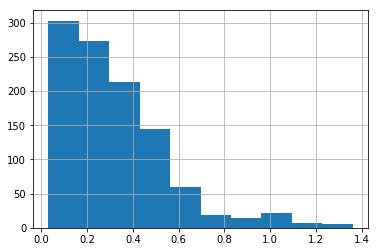

In [29]:
%matplotlib inline
print combined["payments_pct_of_spending_per_student"].describe()
combined["payments_pct_of_spending_per_student"].hist()

## Add year-over-year change

Add columns for year over year changes in weighted grant payments

In [30]:
def last_year(df, city, year, years_ago=1):
    try:
        return df.loc[(city, year-years_ago)]
    except:
        pass
    
print last_year(combined,"ANSONIA",2007)
print("")

print last_year(combined,"ANSONIA",2008)
print("")

print last_year(combined,"ANSONIA",2008,years_ago=2)
print("")

print last_year(combined,"ANSONIA",2009,years_ago=2)
print("")

print "2008"
print last_year(combined,"ANSONIA",2009,years_ago=1)
print("")

print "2009"
print last_year(combined,"ANSONIA",2009,years_ago=0)

None

enrollment                                  2831.14
fte_count                                     489.8
education_spending                      2.96609e+07
has_null_ftes                                 False
grant_payments                          1.90156e+07
fte_count_per_student                      0.173005
education_spending_per_student              10476.7
grant_payments_per_student                   6716.6
payments_pct_of_spending_per_student         0.6411
Name: (ANSONIA, 2007), dtype: object

None

enrollment                                  2831.14
fte_count                                     489.8
education_spending                      2.96609e+07
has_null_ftes                                 False
grant_payments                          1.90156e+07
fte_count_per_student                      0.173005
education_spending_per_student              10476.7
grant_payments_per_student                   6716.6
payments_pct_of_spending_per_student         0.6411
Name: (ANSONIA

In [31]:
def pct_diff(first, second):
    return (float(second) - float(first)) / float(first)
print pct_diff(50,100)
print pct_diff(100, 50)

1.0
-0.5


In [32]:
def change(row, (city,year), col="payments_pct_of_spending_per_student",years_ago=1):
    prev_row = last_year(combined, city, year, years_ago=years_ago)
    if prev_row is None: 
        return
    
    yoy_change = pct_diff(prev_row[col], row[col])
    
    return yoy_change
    

print change(combined.loc[("ANSONIA",2008)],("ANSONIA",2008), col="grant_payments_per_student")
print change(combined.loc[("ANSONIA",2008)],("ANSONIA",2008))

0.0776948871868
-0.157291838444


In [33]:
combined.loc["ANSONIA"]

,enrollment,fte_count,education_spending,has_null_ftes,grant_payments,fte_count_per_student,education_spending_per_student,grant_payments_per_student,payments_pct_of_spending_per_student
report_year,,,,,,,,,
2007,2831.14,489.8,29660930.0,False,19015633.54,0.173005,10476.673707,6716.599511,0.641100
2008,2867.43,391.9,38418010.0,False,20755734.21,0.136673,13398.063771,7238.444952,0.540261
2009,2854.78,404.5,31520992.0,False,21034180.89,0.141692,11041.478503,7368.056694,0.667307
2010,2867.97,373.2,32282747.0,False,21796853.32,0.130127,11256.305680,7600.098090,0.675186
2011,2795.42,399.6,31895845.0,False,22181436.60,0.142948,11410.036774,7934.920906,0.695433
2012,2710.56,389.6,33764768.0,False,21955987.39,0.143734,12456.749897,8100.166530,0.650263
2013,2628.64,376.7,34124712.0,False,21488258.20,0.143306,12981.888733,8174.667585,0.629698
2014,2528.60,391.7,35784832.0,False,22007731.82,0.154908,14152.033536,8703.524409,0.615002
2015,2585.10,347.2,37029834.0,False,22245689.95,0.134308,14324.333295,8605.349870,0.600750


In [34]:
combined["1y_change_weighted_grants"] = combined.apply(
    lambda x: change(x, x.name, years_ago=1),
    axis=1
)
combined.head()

enrollment  fte_count  education_spending  has_null_ftes  \
City    report_year                                                             
ANSONIA 2007            2831.14      489.8          29660930.0          False   
        2008            2867.43      391.9          38418010.0          False   
        2009            2854.78      404.5          31520992.0          False   
        2010            2867.97      373.2          32282747.0          False   
        2011            2795.42      399.6          31895845.0          False   

                     grant_payments  fte_count_per_student  \
City    report_year                                          
ANSONIA 2007            19015633.54               0.173005   
        2008            20755734.21               0.136673   
        2009            21034180.89               0.141692   
        2010            21796853.32               0.130127   
        2011            22181436.60               0.142948   

                     education_spending_per_student  \
City    report_year                                   
ANSONIA 2007                           10476.673707   
        2008                           13398.063771   
        2009                           11041.478503   
        2010                           11256.305680   
        2011                           11410.036774   

                     grant_payments_per_student  \
City    report_year                               
ANSONIA 2007                        6716.599511   
        2008                        7238.444952   
        2009                        7368.056694   
        2010                        7600.098090   
        2011                        7934.920906   

                     payments_pct_of_spending_per_student  \
City    report_year                                         
ANSONIA 2007                                     0.641100   
        2008                                     0.540261   
        2009                                     0.667307   
        2010                                     0.675186   
        2011                                     0.695433   

                     1y_change_weighted_grants  
City    report_year                             
ANSONIA 2007                               NaN  
        2008                         -0.157292  
        2009                          0.235158  
        2010                          0.011807  
        2011                          0.029988

In [35]:
combined["2y_change_weighted_grants"] = combined.apply(
    lambda x: change(x, x.name, years_ago=2),
    axis=1
)
combined.head()

enrollment  fte_count  education_spending  has_null_ftes  \
City    report_year                                                             
ANSONIA 2007            2831.14      489.8          29660930.0          False   
        2008            2867.43      391.9          38418010.0          False   
        2009            2854.78      404.5          31520992.0          False   
        2010            2867.97      373.2          32282747.0          False   
        2011            2795.42      399.6          31895845.0          False   

                     grant_payments  fte_count_per_student  \
City    report_year                                          
ANSONIA 2007            19015633.54               0.173005   
        2008            20755734.21               0.136673   
        2009            21034180.89               0.141692   
        2010            21796853.32               0.130127   
        2011            22181436.60               0.142948   

                     education_spending_per_student  \
City    report_year                                   
ANSONIA 2007                           10476.673707   
        2008                           13398.063771   
        2009                           11041.478503   
        2010                           11256.305680   
        2011                           11410.036774   

                     grant_payments_per_student  \
City    report_year                               
ANSONIA 2007                        6716.599511   
        2008                        7238.444952   
        2009                        7368.056694   
        2010                        7600.098090   
        2011                        7934.920906   

                     payments_pct_of_spending_per_student  \
City    report_year                                         
ANSONIA 2007                                     0.641100   
        2008                                     0.540261   
        2009                                     0.667307   
        2010                                     0.675186   
        2011                                     0.695433   

                     1y_change_weighted_grants  2y_change_weighted_grants  
City    report_year                                                        
ANSONIA 2007                               NaN                        NaN  
        2008                         -0.157292                        NaN  
        2009                          0.235158                   0.040878  
        2010                          0.011807                   0.249741  
        2011                          0.029988                   0.042149

In [36]:
combined.sort_values(by="1y_change_weighted_grants", ascending=False).head()

,,enrollment,fte_count,education_spending,has_null_ftes,grant_payments,fte_count_per_student,education_spending_per_student,grant_payments_per_student,payments_pct_of_spending_per_student,1y_change_weighted_grants,2y_change_weighted_grants
City,report_year,,,,,,,,,,,
NEW HAVEN,2009,18074.31,3173.6,192024547.0,False,2.307514e+08,0.175586,10624.170273,12766.818793,1.201677,0.389663,0.040433
ENFIELD,2009,6398.82,926.4,73847000.0,False,3.387182e+07,0.144777,11540.721571,5293.447234,0.458676,0.363498,0.116240
WATERBURY,2009,17735.58,2868.7,169099000.0,False,1.589314e+08,0.161748,9534.449959,8961.160095,0.939872,0.359363,0.027346
BROOKFIELD,2009,3029.69,435.8,37278699.0,False,3.108510e+06,0.143843,12304.459862,1026.015876,0.083386,0.349242,0.156794
WEST HARTFORD,2009,10111.39,1583.0,132304000.0,False,2.399342e+07,0.156556,13084.650083,2372.910548,0.181351,0.341332,0.214413


In [37]:
combined.loc["ENFIELD"]

,enrollment,fte_count,education_spending,has_null_ftes,grant_payments,fte_count_per_student,education_spending_per_student,grant_payments_per_student,payments_pct_of_spending_per_student,1y_change_weighted_grants,2y_change_weighted_grants
report_year,,,,,,,,,,,
2007,6584.14,953.2,72357000.0,False,29732316.30,0.144772,10989.590136,4515.747888,0.410911,NaN,NaN
2008,6437.02,964.7,97560000.0,False,32818810.84,0.149867,15156.081541,5098.447859,0.336396,-0.181341,NaN
2009,6398.82,926.4,73847000.0,False,33871816.03,0.144777,11540.721571,5293.447234,0.458676,0.363498,0.116240
2010,6215.03,927.7,65002000.0,False,37068913.67,0.149267,10458.839298,5964.398188,0.570273,0.243305,0.695244
2011,6051.60,811.8,70698000.0,False,35240913.89,0.134146,11682.530240,5823.404371,0.498471,-0.125909,0.086762
2012,5917.68,795.0,71140000.0,False,36153551.16,0.134343,12021.603061,6109.413006,0.508203,0.019523,-0.108844
2013,5766.68,814.6,73344000.0,False,34886916.71,0.141260,12718.583310,6049.740355,0.475661,-0.064032,-0.045759
2014,5597.19,834.8,77039000.0,False,35133902.80,0.149146,13763.870799,6277.060954,0.456053,-0.041223,-0.102615
2015,5555.28,842.2,73482000.0,False,35151979.58,0.151604,13227.416080,6327.670177,0.478375,0.048946,0.005705


In [38]:
combined["1y_change_grants_per_student"] = combined.apply(
    lambda x: change(x, x.name, years_ago=2,col="grant_payments_per_student"),
    axis=1
)
combined.head()

enrollment  fte_count  education_spending  has_null_ftes  \
City    report_year                                                             
ANSONIA 2007            2831.14      489.8          29660930.0          False   
        2008            2867.43      391.9          38418010.0          False   
        2009            2854.78      404.5          31520992.0          False   
        2010            2867.97      373.2          32282747.0          False   
        2011            2795.42      399.6          31895845.0          False   

                     grant_payments  fte_count_per_student  \
City    report_year                                          
ANSONIA 2007            19015633.54               0.173005   
        2008            20755734.21               0.136673   
        2009            21034180.89               0.141692   
        2010            21796853.32               0.130127   
        2011            22181436.60               0.142948   

                     education_spending_per_student  \
City    report_year                                   
ANSONIA 2007                           10476.673707   
        2008                           13398.063771   
        2009                           11041.478503   
        2010                           11256.305680   
        2011                           11410.036774   

                     grant_payments_per_student  \
City    report_year                               
ANSONIA 2007                        6716.599511   
        2008                        7238.444952   
        2009                        7368.056694   
        2010                        7600.098090   
        2011                        7934.920906   

                     payments_pct_of_spending_per_student  \
City    report_year                                         
ANSONIA 2007                                     0.641100   
        2008                                     0.540261   
        2009                                     0.667307   
        2010                                     0.675186   
        2011                                     0.695433   

                     1y_change_weighted_grants  2y_change_weighted_grants  \
City    report_year                                                         
ANSONIA 2007                               NaN                        NaN   
        2008                         -0.157292                        NaN   
        2009                          0.235158                   0.040878   
        2010                          0.011807                   0.249741   
        2011                          0.029988                   0.042149   

                     1y_change_grants_per_student  
City    report_year                                
ANSONIA 2007                                  NaN  
        2008                                  NaN  
        2009                             0.096992  
        2010                             0.049963  
        2011                             0.076935

In [40]:
combined.to_csv("output/combined.csv")

In [44]:
%matplotlib inline

In [45]:
combined.groupby("report_year").agg({"grant_payments":sum})

,grant_payments
report_year,
2007,2.105460e+09
2008,2.301557e+09
2009,2.385681e+09
2010,2.513367e+09
2011,2.510345e+09
2012,2.498241e+09
2013,2.575113e+09
2014,2.674104e+09
2015,2.753102e+09


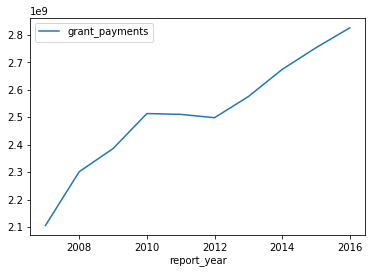

In [46]:
combined.groupby("report_year").agg({"grant_payments":sum}).plot()

In [52]:
grants[grants["Grantname"].str.contains("ARRA")]["Grantname"].unique()

array(['ARRA IDEA PART B  SECTION', 'ARRA   EDUCATIONAL TECHNOLOGY',
       'ARRA   IDEA  PART B  SECTION  PRE SCHOOL',
       'ARRA MCKINNEY VENTO HOMELESS CHILDREN   YOUTH',
       'ARRA NSLP EQUIPMENT ASSISTANCE GRANT',
       'ARRA STABILIZATION ED GRANTS', 'ARRA STABILIZATION GOV SERV',
       'ARRA TITLE I IMPROVING BASIC PROGRAMS',
       'ARRA   TITLE I   LOCAL N   D', 'ARRA SCHOOL IMPROVEMENT GRANT'],
      dtype=object)